# CAPSTONE FINAL PROJECT

## Introduction/Problem statement
#### In the recent years, the japanese dish sushi has become more and more popular and many sushi shops have opened in New York city and its borough. With so over 100 of shops to chose from, it has become a problem for people to find the best one to pick to satisfy their sushi cravings. Since it is notpossible to pick a restaurant for someone because everyone has a different taste, it is better to find out which borough have the best ratings for sushi places. In this manner, people candecide which sushi place suits them the most knowing that all the sushi places around them are of high ratings. This project is aimed to help sushi lovers to find in which borough the highest ratings sushi places are located.

## Data
#### In order to be able to reach a conclusion, data analysis of existing shops in New York city has to be performed. Two sets of essential data are to be looked at. Firstly, the location,i.e the neighborhood of New York city and this data has been collected from the following url https://cocl.us/new_york_dataset. Secondly,I am using Foursquare API to find the sushi shops.


In [1]:
!pip install folium

     |████████████████████████████████| 92kB 15.7MB/s eta 0:00:01


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from os import path
from PIL import Image

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

In [3]:
import urllib.request
urllib.request.urlretrieve("https://cocl.us/new_york_dataset", 'newyork_data.json')
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

## Methodology

#### During this analysis process, data analysis and visualization such as bar charts will be made in order to find the borough with the sushi place with the best ratings y collecting data from Foursquare.


In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [20]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork)  
    
map_newyork

In [21]:
CLIENT_ID = 'EM0ZT3XUTK4ZXUJQNBU0OSFQNDBME1PF2CBSAS2YVRAPUBVB' # your Foursquare ID
CLIENT_SECRET = 'PKQQKNLPGQGFWXMHCN3YS3ZEGHKZGMNYC5DQOXSHD1O2I0VZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EM0ZT3XUTK4ZXUJQNBU0OSFQNDBME1PF2CBSAS2YVRAPUBVB
CLIENT_SECRET:PKQQKNLPGQGFWXMHCN3YS3ZEGHKZGMNYC5DQOXSHD1O2I0VZ


In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['venue']['id'],
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'id',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:

LIMIT = 100
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [24]:
ny_venues.head()

,Neighborhood,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,4c537892fd2ea593cb077a28,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,4d375ce799fe8eec99fd2355,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,4c9e50e38afca09379b2ff15,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,4c783cef3badb1f7e4244b54,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,4c1bed4eb306c928140763b7,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint


In [25]:
sushi_rest = ny_venues[ny_venues['Venue Category']=="Sushi Restaurant"].reset_index(drop=True).drop_duplicates(subset=['id'], keep='first')
sushi_rest.head()
sushi_rest.shape

(147, 8)

In [26]:
map_newyork_sushi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, ven in zip(sushi_rest['Venue Latitude'], sushi_rest['Venue Longitude'], sushi_rest['Venue']):
    label = folium.Popup(str(ven), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork_sushi)  
    
map_newyork_sushi

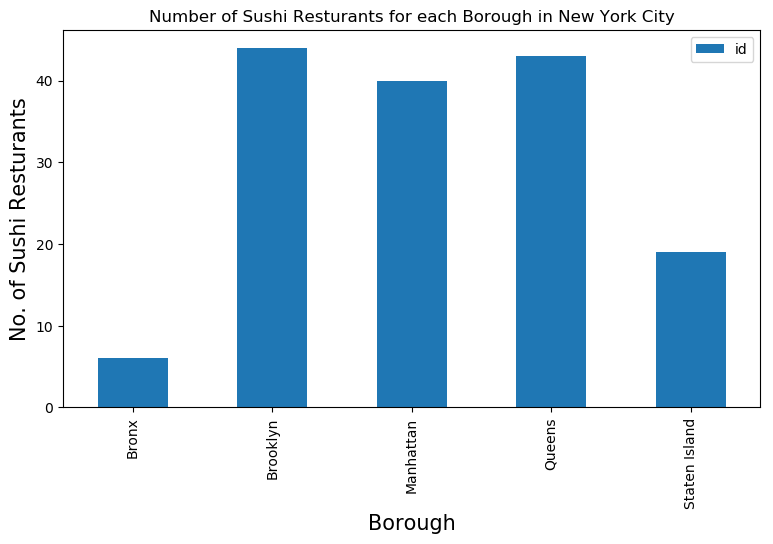

In [27]:
sushi_rest_b = pd.merge(sushi_rest, neighborhoods[["Neighborhood","Borough"]]  , on='Neighborhood')
# Then we plot
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Sushi Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No. of Sushi Resturants', fontsize=15)
#giving a bar plot
sushi_rest_b.groupby('Borough')['id'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [28]:
per_N = sushi_rest_b.groupby('Neighborhood')['Venue'].count().reset_index(name="count")
per_N.sort_values('count', ascending=False ).head(10)

,Neighborhood,count
54,Murray Hill,6
73,Sheepshead Bay,5
45,Manhattan Terrace,4
25,Eltingville,4
6,Bayside,4
64,Prospect Heights,3
33,Hamilton Heights,3
27,Forest Hills,3
39,Kew Gardens Hills,3
40,Lenox Hill,3


In [37]:
# collecting ratingsetc
sushi_rest_b["Rating"] = np.nan
sushi_rest_b["Likes"] = np.nan
sushi_rest_b["No. of Ratings"] = np.nan
venue_data = []

In [38]:
for i in range(0,len(sushi_rest_b)):
    ID = sushi_rest_b['id'][i]
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        ID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    # continue in case any information is not available
    try:
        sushi_rest_b["Likes"][i] =venue_data['likes']['count']
    except KeyError:
        pass
    try:
        sushi_rest_b["Rating"][i] = venue_data['rating']
        sushi_rest_b["No. of Ratings"][i] = venue_data['ratingSignals']
    except KeyError:
        pass

KeyError: 'venue'

## Results

#### In this section, I will present my findings by displaying the highest rating sushi places.

In [31]:
sushi_rest_b.sort_values('Rating', ascending=False ).reset_index(drop=True)

,Neighborhood,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,Rating,Likes,No. of Ratings
0,Prospect Heights,532f5fd3498e2f7f41aab662,40.676822,-73.964859,Silver Rice,40.674187,-73.957037,Sushi Restaurant,Brooklyn,9.1,277.0,356.0
1,Williamsburg,423e0e80f964a52048201fe3,40.707144,-73.958115,Bozu,40.712976,-73.957478,Sushi Restaurant,Brooklyn,9.1,506.0,700.0
2,Prospect Heights,49f50c9ff964a5208a6b1fe3,40.676822,-73.964859,Gen,40.677575,-73.963721,Sushi Restaurant,Brooklyn,9.0,203.0,269.0
3,Prospect Lefferts Gardens,56f0a695cd1075cd28419327,40.658420,-73.954899,Silver Rice,40.659673,-73.960368,Sushi Restaurant,Brooklyn,8.8,40.0,52.0
4,Sheepshead Bay,4b9fc706f964a520cc3d37e3,40.586890,-73.943186,Mitoushi Sushi,40.585693,-73.951782,Sushi Restaurant,Brooklyn,8.7,53.0,68.0
5,Boerum Hill,58d7f76b0393cc26f48858c6,40.685683,-73.983748,Taiki,40.684500,-73.983783,Sushi Restaurant,Brooklyn,8.7,39.0,54.0
6,Greenpoint,5b809669b9a5a8002c0c871b,40.730201,-73.954241,Chiko,40.731871,-73.954369,Sushi Restaurant,Brooklyn,8.6,10.0,15.0
7,Brooklyn Heights,4b6b6ad0f964a52066072ce3,40.695864,-73.993782,Sushi Gallery,40.697595,-73.993236,Sushi Restaurant,Brooklyn,8.6,39.0,54.0
8,Prospect Heights,59ee5d302632ec3b0a1ffbb4,40.676822,-73.964859,Sushi Lin,40.677689,-73.972804,Sushi Restaurant,Brooklyn,8.6,33.0,49.0
9,Downtown,49e63b62f964a52027641fe3,40.690844,-73.983463,Ki Sushi,40.687574,-73.989936,Sushi Restaurant,Brooklyn,8.6,197.0,300.0


#### considering that any sushiplace with a rating less than 8 is considered bad rating, I am dropping all the sushi place with a bad rating


In [32]:
sushi_rest_hr = sushi_rest_b[sushi_rest_b['Rating'] >=8.0]

sushi_rest_hr.shape

(17, 12)

In [33]:
sushi_neighborhood=sushi_rest_b.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating','No. of Ratings','Likes']]

pd.merge(sushi_neighborhood, per_N, on='Neighborhood').sort_values(['Rating'],ascending=False).head(10)

,Neighborhood,Rating,No. of Ratings,Likes,count
85,Williamsburg,9.10,700.000000,506.0,1
64,Prospect Heights,8.90,224.666667,171.0,3
65,Prospect Lefferts Gardens,8.80,52.000000,40.0,1
9,Boerum Hill,8.70,54.000000,39.0,1
12,Brooklyn Heights,8.60,54.000000,39.0,1
23,Downtown,8.60,300.000000,197.0,1
14,Bushwick,8.20,43.000000,30.0,1
31,Greenpoint,8.05,67.500000,42.0,2
28,Fort Hamilton,8.00,40.000000,26.0,1
73,Sheepshead Bay,7.82,55.600000,34.8,5


In [34]:
sushi_Borough=sushi_rest_b.groupby('Borough',as_index=False).mean()[['Borough','Rating','No. of Ratings','Likes']]
sushi_Borough.sort_values(['Rating'],ascending=False).head(10)

,Borough,Rating,No. of Ratings,Likes
1,Brooklyn,7.689744,77.333333,50.439024
0,Bronx,7.425000,20.250000,7.500000
2,Manhattan,7.300000,89.000000,54.333333
3,Queens,NaN,NaN,NaN
4,Staten Island,NaN,NaN,NaN


## Discussion

#### From the above analysis it has been found that the top three boroughs which have the highest ratings and most likes are Brooklyn, Bronx and Manhattan. This information has made it possible for us to decide that Brooklyn has the highest rating for the best sushi location.


## Conclusion

#### In conclusion, this project has made it possible to identify which borough has the highest rating for the best sushi plaace and has made it easier for sushi lovers to find a location to pick a restaurant to eat from. From the analysis performed in this project, Brooklyn was found to be the borough with the highest rating of 7.69.